## Background



In [1]:
import muq.Modeling as mm 
import muq.SamplingAlgorithms as ms 
import muq.Utilities as mu
import muq.Approximation as ma 
import muq.Optimization as mo

from FlowEquation import FlowEquation

import numpy as np
import matplotlib.pyplot as plt 

## Define Problem

In [2]:
class Discretization:
    
    def __init__(self,numCells):
        self.numCells = numCells
        self.numNodes = numCells+1

        self.nodeLocs = np.linspace(0,1,numCells+1)

        self.cellLocs = 0.5*(self.nodeLocs[:-1] + self.nodeLocs[1:]).reshape(1,-1)

In [3]:
def GetTrueLogConductivity(mesh):
    return np.cos(10.0*mesh.cellLocs)

In [4]:
def GenerateData(mesh, obsThin, obsVar):

    # Generate the data
    numRefine = 1
    fineMesh = Discretization(numRefine*mesh.numCells)
    trueCond = np.exp( GetTrueLogConductivity(fineMesh) )

    # Create the model with twice the mesh resolution
    recharge = np.ones(fineMesh.numCells)
    mod = FlowEquation(recharge)

    # Solve the forward problem with the true conductivity
    trueSol = mod.Evaluate( trueCond )[0]

    # Take every N node as an "observation"
    slicer = mm.SliceOperator(fineMesh.numNodes,0,fineMesh.numCells,numRefine*obsThin)

    return slicer.Evaluate([trueSol])[0] + np.sqrt(obsVar)*np.random.randn(slicer.outputSizes[0])

In [5]:
def CreatePrior(mesh):
    
    # Define the prior distribution
    priorVar    = 1.0
    priorLength = 0.05
    priorNu     = 3.0/2.0
    
    covKernel = ma.MaternKernel(1, priorVar, priorLength, priorNu) # The first argument "1" specifies we are working in 1d
    
    meanFunc = ma.ZeroMean(1,1) # dimension of x, components in k(x) if it was vector-valued

    priorGP = ma.GaussianProcess(meanFunc,covKernel)

    return priorGP.Discretize(mesh.cellLocs)

In [6]:
def ConstructGraph(mesh, data, obsThin, obsVar):
   
    # Define the forward model
    recharge = np.ones(mesh.numCells)
    forwardMod = FlowEquation(recharge)
    
    graph = mm.WorkGraph()
    graph.AddNode(mm.IdentityOperator(mesh.numCells), "Log Conductivity")
    graph.AddNode(mm.ExpOperator(mesh.numCells), "Conductivity")
    graph.AddEdge("Log Conductivity", 0, "Conductivity", 0)

    graph.AddNode(forwardMod, "Forward Model")
    graph.AddEdge("Conductivity", 0, "Forward Model", 0)
    graph.AddNode(mm.SliceOperator(mesh.numNodes,0,mesh.numCells,obsThin), "Observables")
    graph.AddEdge("Forward Model", 0, "Observables", 0)
    
    
    priorDist = CreatePrior(mesh)
    likelihood = mm.Gaussian(data, obsVar*np.ones(data.shape[0]))

    graph.AddNode(likelihood.AsDensity(), "Likelihood")
    graph.AddEdge("Observables", 0, "Likelihood", 0)
    
    graph.AddNode(priorDist.AsDensity(), "Prior")
    graph.AddEdge("Log Conductivity", 0, "Prior", 0)
    
    graph.AddNode(mm.DensityProduct(2), "Posterior")
    graph.AddEdge("Prior",0,"Posterior",0)
    graph.AddEdge("Likelihood",0,"Posterior",1)

    graph.Visualize("WorkGraph.pdf")
    
    return graph

In [7]:
# Define the mesh
numCells = 50
mesh = Discretization(numCells)

# Generate synthetic "truth" data
obsThin = 4
obsVar = 0.01*0.01
data = GenerateData(mesh, obsThin, obsVar)

graph = ConstructGraph(mesh, data, obsThin, obsVar)
posterior = graph.CreateModPiece('Posterior')
model = graph.CreateModPiece('Forward Model')

## Compute MAP Point

In [8]:
def ComputeMAP(logPost, startPt):
    
    options = {
        'Algorithm' : 'NewtonTrust', # Newton-Steihaug trust region method.  Options also include NLOPT optimizers like LBFGS
        'PrintLevel' : 1,
        'Ftol.AbsoluteTolerance' : 1e-4
    }
    
    # Define the objective function as the negative log posterior 
    objective = mo.ModPieceCostFunction(logPost, -1.0)
    
    # Construct the optimizer and minimize the objective
    solver = mo.Optimizer.Construct(objective, options)
    xopt, fopt = solver.Solve([ startPt ])
    
    return xopt

In [9]:
# Use a random draw from the prior as a starting point for MCMC
startPt = CreatePrior(mesh).GetMean()

mapPt = ComputeMAP(posterior, startPt)

Using NewtonTrust optimizer...
  Iteration, TrustRadius,       fval,      ||g||
          0,       1.000,  5.575e+02,  6.975e+02
          1,       1.000,  1.235e+02,  1.347e+02
          2,       1.000,  5.848e+01,  1.816e+02
          3,       1.000,  2.816e-01,  7.242e+01
          4,       1.000,  -2.197e+01,  5.042e+01
          5,       1.000,  -2.987e+01,  1.406e+01
          6,       1.000,  -3.159e+01,  3.491e+01
          7,       1.000,  -3.285e+01,  3.511e+00
          8,       1.000,  -3.317e+01,  5.887e+00
          9,       1.000,  -3.319e+01,  1.367e+00
         10,       1.000,  -3.319e+01,  6.639e-01
         11,       1.000,  -3.319e+01,  2.622e-01


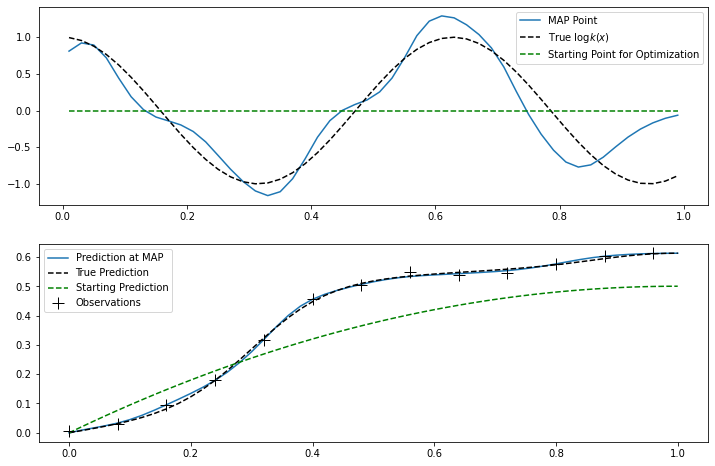

In [10]:
trueLogK = GetTrueLogConductivity(mesh).ravel()

fig, axs = plt.subplots(nrows=2,figsize=(12,8))
axs[0].plot(mesh.cellLocs.ravel(), mapPt,label='MAP Point')
axs[0].plot(mesh.cellLocs.ravel(), trueLogK, '--k', label='True $\log k(x)$')
axs[0].plot(mesh.cellLocs.ravel(), startPt, '--g', label='Starting Point for Optimization')
axs[0].legend()

truePred = model.Evaluate([trueLogK])[0]
mapPred = model.Evaluate([mapPt])[0]
startPred = model.Evaluate([startPt])[0]

axs[1].plot(mesh.nodeLocs, mapPred, label='Prediction at MAP')
axs[1].plot(mesh.nodeLocs, truePred,'--k',label='True Prediction')
axs[1].plot(mesh.nodeLocs, startPred, '--g', label='Starting Prediction')
axs[1].plot(mesh.nodeLocs[0:-1:obsThin],data,'+k',markersize=12,label='Observations')
axs[1].legend()

plt.show()

## Sample Posterior with DILI

In [11]:
def SampleDILI(posterior, startPt, numSamps):
    
    lisOpts = {
        'Method' : "MHKernel",
        "Proposal" : "Prop",
        "Prop.Method" : "MALAProposal",
        "Prop.StepSize" : 0.15
    }
    
    csOpts = {
        "Method" : "MHKernel",
        "Proposal" : "Prop",
        "Prop.Method" : "CrankNicolsonProposal",
        "Prop.Beta" : 0.8,
        "Prop.PriorNode" : "Prior"
    }
    
    opts = {
        "NumSamples" : numSamps,
        "BurnIn" : 0,
        "PrintLevel" : 3,
        "HessianType" : "Exact",
        "Adapt Interval" : 0,
        "Initial Weight" : 100,
        "Prior Node" : "Prior",
        "Likelihood Node" : "Likelihood",
        "LIS Block": "LIS",
        "LIS" : lisOpts,
        "CS Block": "CS",
        "CS" : csOpts
    }
    
    # create a sampling problem
    problem = ms.SamplingProblem(posterior)
    
    # Construct the DILI kernel and MCMC sampler
    kernel = ms.DILIKernel(opts, problem)
    sampler = ms.SingleChainMCMC(opts, [kernel])
    
    return sampler.Run([startPt]) 

In [12]:
numSamps = 100000
diliSamps = SampleDILI(posterior, mapPt, numSamps)

Starting single chain MCMC sampler...
  10% Complete
    Block 0:
       LIS (dim=14): MHKernel acceptance Rate = 49%
       CS: MHKernel acceptance Rate = 27%
  20% Complete
    Block 0:
       LIS (dim=14): MHKernel acceptance Rate = 45%
       CS: MHKernel acceptance Rate = 27%
  30% Complete
    Block 0:
       LIS (dim=14): MHKernel acceptance Rate = 45%
       CS: MHKernel acceptance Rate = 27%
  40% Complete
    Block 0:
       LIS (dim=14): MHKernel acceptance Rate = 44%
       CS: MHKernel acceptance Rate = 26%
  50% Complete
    Block 0:
       LIS (dim=14): MHKernel acceptance Rate = 45%
       CS: MHKernel acceptance Rate = 27%
  60% Complete
    Block 0:
       LIS (dim=14): MHKernel acceptance Rate = 45%
       CS: MHKernel acceptance Rate = 27%
  70% Complete
    Block 0:
       LIS (dim=14): MHKernel acceptance Rate = 45%
       CS: MHKernel acceptance Rate = 28%
  80% Complete
    Block 0:
       LIS (dim=14): MHKernel acceptance Rate = 43%
       CS: MHKernel acceptan

In [13]:
diliEss = diliSamps.ESS(method='MultiBatch')
print('DILI:\n  Multivariate ESS: {:5d}'.format(int(diliEss[0])))

DILI:
  Multivariate ESS:  2139


### Plot DILI Results

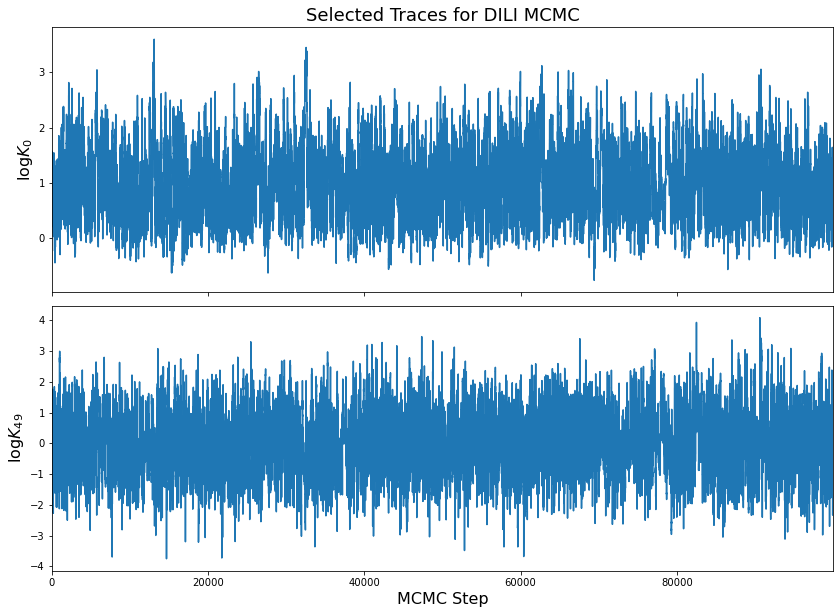

In [14]:
samps = diliSamps.AsMatrix()

fig, axs = plt.subplots(nrows=2,sharex=True,figsize=(14,10))
axs[0].plot(samps[0,:])
axs[0].set_ylabel('$\log K_0\f$',fontsize=16)
axs[0].set_title('Selected Traces for DILI MCMC',fontsize=18)

axs[1].plot(samps[-1,:])
axs[1].set_ylabel('$\log K_{{ {} }}$'.format(samps.shape[0]-1),fontsize=16)
axs[1].set_xlabel('MCMC Step', fontsize=16)
axs[1].set_xlim([0,samps.shape[1]-1])

plt.subplots_adjust(hspace=0.05)

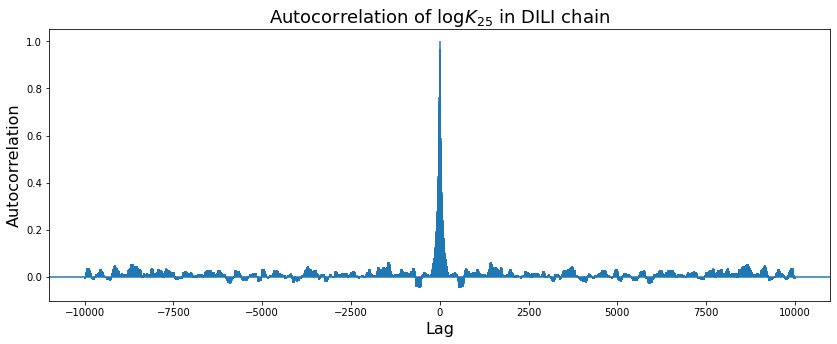

In [15]:
plt.figure(figsize=(14,5))

plotInd = int(0.5*samps.shape[0])
plt.acorr(samps[plotInd,:]-np.mean(samps[plotInd:]),maxlags=10000)
plt.xlabel('Lag', fontsize=16)
plt.ylabel('Autocorrelation', fontsize=16)
plt.title('Autocorrelation of $\log K_{{ {} }}$ in DILI chain'.format(plotInd),fontsize=18)
plt.show()

## Sample Posterior with pCN

In [16]:
def SamplePCN(posterior, startPt, numSamps):
    
    kernOpts = {
        "Method" : "MHKernel",
        "Proposal" : "Prop",
        "Prop.Method" : "CrankNicolsonProposal",
        "Prop.Beta" : 0.1,
        "Prop.PriorNode" : "Prior"
    }
    
    opts = {
        "NumSamples" : numSamps, # number of Monte Carlo samples,
        "BurnIn" : 0,
        "PrintLevel" : 3,
        "KernelList" : "Kernel1",
        "Kernel1" : kernOpts
    }
    
    
    #create a sampling problem
    problem = ms.SamplingProblem(posterior)

    sampler = ms.SingleChainMCMC(opts,problem)

    return sampler.Run([startPt]) # Use a true posterior sample to avoid burnin

In [17]:
pcnSamps = SamplePCN(posterior, startPt, numSamps)

Starting single chain MCMC sampler...
  10% Complete
    Block 0:
      MHKernel acceptance Rate = 9%
  20% Complete
    Block 0:
      MHKernel acceptance Rate = 9%
  30% Complete
    Block 0:
      MHKernel acceptance Rate = 9%
  40% Complete
    Block 0:
      MHKernel acceptance Rate = 9%
  50% Complete
    Block 0:
      MHKernel acceptance Rate = 9%
  60% Complete
    Block 0:
      MHKernel acceptance Rate = 9%
  70% Complete
    Block 0:
      MHKernel acceptance Rate = 9%
  80% Complete
    Block 0:
      MHKernel acceptance Rate = 9%
  90% Complete
    Block 0:
      MHKernel acceptance Rate = 9%
  100% Complete
    Block 0:
      MHKernel acceptance Rate = 9%
Completed in 32.6869 seconds.


In [18]:
pcnEss = pcnSamps.ESS(method='MultiBatch')
print('pCN:\n  Multivariate ESS: {:5d}'.format(int(pcnEss[0])))

pCN:
  Multivariate ESS:   381


### Plot pCN Results

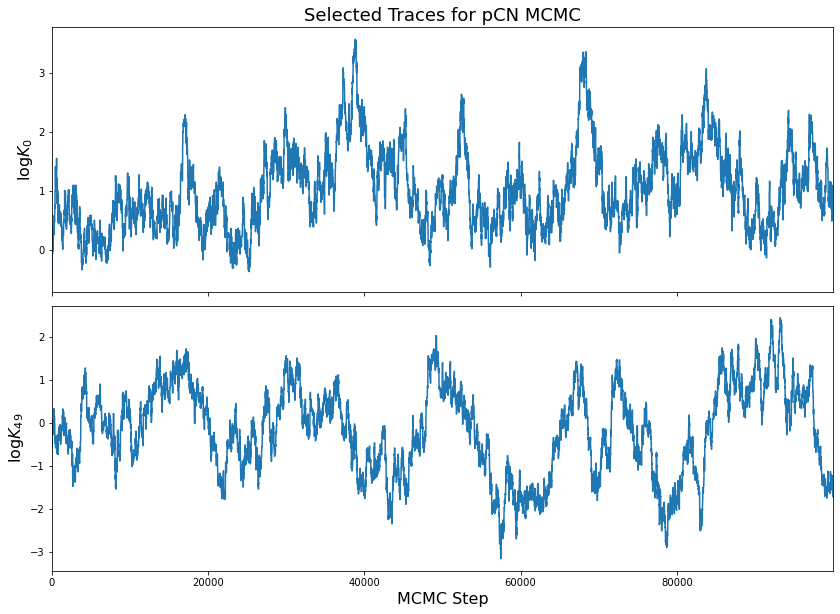

In [19]:
samps = pcnSamps.AsMatrix()

fig, axs = plt.subplots(nrows=2,sharex=True,figsize=(14,10))
axs[0].plot(samps[0,:])
axs[0].set_ylabel('$\log K_0\f$',fontsize=16)
axs[0].set_title('Selected Traces for pCN MCMC',fontsize=18)

axs[1].plot(samps[-1,:])
axs[1].set_ylabel('$\log K_{{ {} }}$'.format(samps.shape[0]-1),fontsize=16)
axs[1].set_xlabel('MCMC Step', fontsize=16)
axs[1].set_xlim([0,samps.shape[1]-1])

plt.subplots_adjust(hspace=0.05)


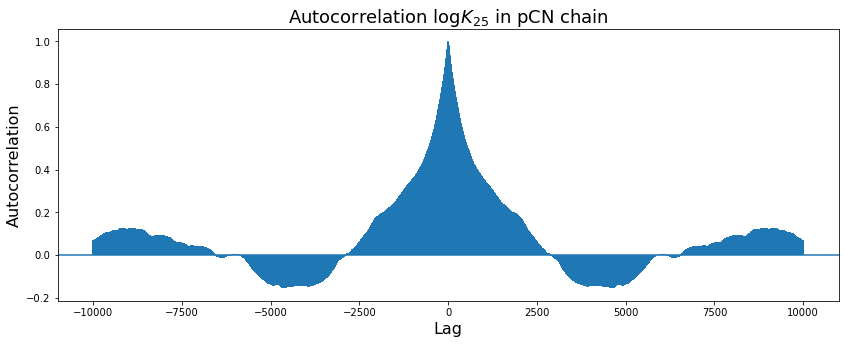

In [20]:
plt.figure(figsize=(14,5))

plt.acorr(samps[plotInd,:]-np.mean(samps[plotInd:]),maxlags=10000)
plt.xlabel('Lag', fontsize=16)
plt.ylabel('Autocorrelation', fontsize=16)
plt.title('Autocorrelation $\log K_{{ {} }}$ in pCN chain'.format(plotInd),fontsize=18)
plt.show()